# Measuring Customers

Any time that an *interaction* occurs between a customer and a product, that is considered an *event*. Events are stored in the database with timestamps. Converting event data into metrics that summarize each customer's behavior is a crucial step. There are many ways to do this, so we'll cover some of them in this notebook. Just like an *event*, a *metric* also has a timestamp, but a metric's timestamp summarizes behavior over a time window. Looking at events by themselves doesn't tell us much about the customer, so aggregating their behavior into a single metric is an effective way to analyze their behavior. Metrics should summarize behavior multiple times over a customer's lifespan. This is especially true in the context of churn, because customer engagement is dynamic by nature, so observing how metrics change over time helps us understand how their engagement changes over time.  

The purpose of this notebook is focused on explaining the strategies that may be used to create an effective customer metric. We'll use a different dataset for this analysis that contains transactional data with timestamps for different customers. This data won't tell us whether a customer has churned or not, but raw data will often contain many rows corresponding to different events which will need to be aggregated for posterior analysis. We'll also cover some techniques for data *quality assurance (QA)*.

### Data Import and Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
# importing raw csv file as pandas dataframe
df = pd.read_csv('../data/raw/Transactions.csv', usecols=[0,1,2,3,4,5])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 291.3+ MB


## Creating metrics from events

Each user will have a series of events over their lifespan. For credit cards, each event is a transaction. Transactions can be identified by three components:

- When did the transaction occur? (timestamp)
- What type of transaction was it? 
- Who made the transaction? (ID)

These are the keys in this data that make each row unique. Keep in mind that with timestamps, we are limited by the smallest interval of time in that variable. For example, if we only know the calendar date of a transaction, then there might be multiple transactions by the same account on the same day, but we won't know at what hour the transactions occurred. This is not a problem, because we define a specific *time period* that we think is approriate for our analysis. Time periods are described by their length, so we calculate metrics for each customer over a range of repeated time periods. For our dataset we have the `step` variable that corresponds to one unit of time. We can look at all events with intervals of 100 steps to generate metrics, which is an arbitrary choice for simplicity. Metrics can be as simple as counting the number of events in each time period to more complex derivations. The metrics can only be calculated once the time period ends, so that all possible events within that time period have been observed.

In the plot below, we can see how different accounts transact at different times and that the transactions correspond to different amounts.

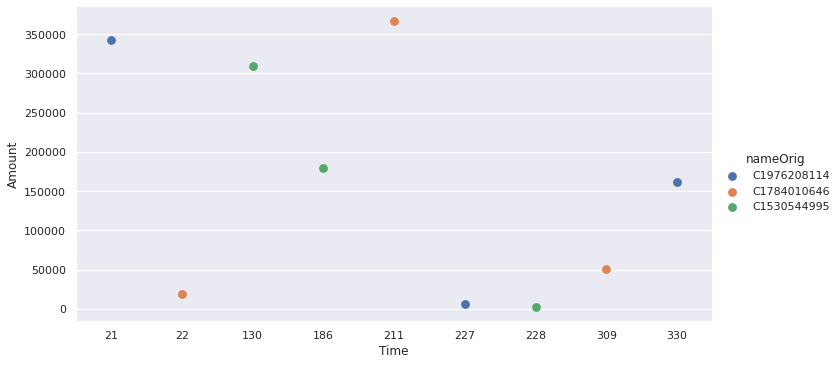

In [150]:
# taking subsample of accounts
three_trx = df.query("nameOrig == 'C1530544995' | nameOrig == 'C1784010646' | nameOrig == 'C1976208114'")

# plotting events
g = sns.catplot(data=three_trx, x='step', y='amount', hue='nameOrig', join=False, kind='point', aspect=2)
g.set_axis_labels('Time', 'Amount')
plt.show()

## Counting events

Now we will calculate metrics for each account and each event that occured in their lifespan. Every event in the data occurs within a specific time period. These calculations can be done in SQL, but this notebook will do it in python. SQL is more optimal if the data is very large, which is often the case with event data. To count the number of events in each time period, we must follow a squence of steps:

1. Specify a specific time frame (e.g. step 101 - 200)
2. Look at all events within that period of a specific type (e.g. CASH-OUT)
3. Count the total number of events for each account

Since the simulation dataset is not very large, most accounts do not have more than 1 transaction, but keep in mind that real data will often include many transactions for each account even in short time intervals.

In [67]:
# filtering for step 101-200
count = df[(df['step'] > 100) & (df['step'] <=200)]

# filtering for CASH-OUT
count_cash = count[count['type'] == 'CASH_OUT']

# grouping by account and counting
count_group = count_cash.groupby('nameOrig')['amount'].count().reset_index().rename(columns={'amount':'count'})
count_group.head()

,nameOrig,count
0,C1000005555,1
1,C1000008975,1
2,C1000013879,1
3,C1000015836,1
4,C1000025091,1


## Defining metric periods

### Weekly cycles

Customers tend to show cyclical behavior over weeks. For example, people might be more likely to use their credit card on the weekends, when they go out to eat and engage in other leisure activites. If this is true, then most events will occur between Friday and Sunday, so a time period should include an equal number of days where product usage tends to be both high and low. Not doing this might generate some artificial increases in usage for time periods that have more weekends than others, for example. We can try to catch these trends visually by plotting the average transaction amounts for all time steps in the data.

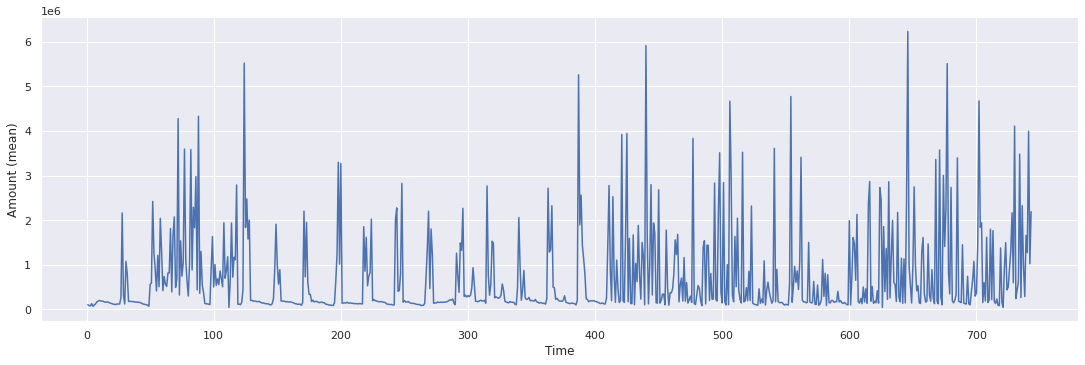

In [79]:
# grouping by time step and calculating average amount
avg_amount = df.groupby('step')['amount'].mean().reset_index()

# plotting average transaction amount per time step
g = sns.relplot(data=avg_amount, x='step', y='amount', kind='line', aspect=3)
g.set_axis_labels('Time', 'Amount (mean)')
plt.show()

### Timestamps for metrics

The plot above shows the trends for every single time step, but we want to do some aggregation when calculating metrics, like we did when calculating counts. When we do these groupings, the metrics themselves need a *timestamp* corresponding to the period covered. If we measured counts between time step 101-200, then best practices is to use the time stamp of the immediate subsequent time step, in this case 201. This is an arbitrary convention, but it helps organize dates cleanly in one column as opposed to having two columns for start and end of each bin. This is a simple convention, but it helps avoids subtle errors with data wrangling and syncing with databases. Let's look at a python example.

In [145]:
# grouping by intervals of 100 steps and calculting average transaction amount for each bin
timestamp = []
avg_amount = []
for t in np.arange(100, 900, 100):
    avg_amount.append(round(df[(df['step'] > (t-100)) & (df['step'] <= t)]['amount'].mean(), 2))
    timestamp.append(t+1)
    
# creating dataframe for all intervals
interval = pd.DataFrame({'timestamp':timestamp, 'avg_amount':avg_amount})
interval.head()

,timestamp,avg_amount
0,101,158328.68
1,201,160308.24
2,301,162913.34
3,401,230030.93
4,501,158880.76


## Different points in time

So far we have calculated metrics over disjoint time intervals, but we need to generate some sort of comparison between these metrics to understand how they relate to churn behavior.

### Overlapping time periods

Customer metrics are bound to change over each account's lifespan, which we did previously by making aggregations over a fixed interval. This is not always optimal, though, because having fixed intervals means that we must wait until each time period is over before generating any metric for that window. Sometimes we might want to have a more real-time metric that can be checked more often and is more dynamic. To do this, we can use a moving window and calculate the metric for each window. This doesn't mean we have to calculate it for each day, but we can, for example, calculate transaction counts for each account every 25 time steps for the past 100 time steps. Since our data does not have a lot of transactions per account, we'll show the average transactions for each window, which is just an extra step in the calculations. This involves a sequence of steps:

1. Choose sequence of moving windows smaller than periods (e.g. period = 100 steps, window = 25 steps)
2. For each date, select the events of interest (e.g. CASH_OUT)
3. Count the number of events for each account and date

In [86]:
# grouping by moving intervals of 100 steps every 25 steps and calculting average transaction amount for each bin
timestamp = []
avg_count = []
for t in np.arange(100, 900, 25):
    count_window = df[(df['step'] > (t-100)) & (df['step'] <= t) & (df['type'] == 'CASH_OUT')]
    moving_count = count_window.groupby('nameOrig')['amount'].count().reset_index().rename(columns={'amount':'count'})
    avg_count.append(moving_count['count'].mean())
    timestamp.append(t+1)
    
# creating dataframe for all intervals
interval = pd.DataFrame({'timestamp':timestamp, 'avg_count':avg_count})
interval.head(n=10)

,timestamp,avg_count
0,101,1.000093
1,126,1.000035
2,151,1.000054
3,176,1.000066
4,201,1.000114
5,226,1.000157
6,251,1.000161
7,276,1.000158
8,301,1.000152
9,326,1.000146


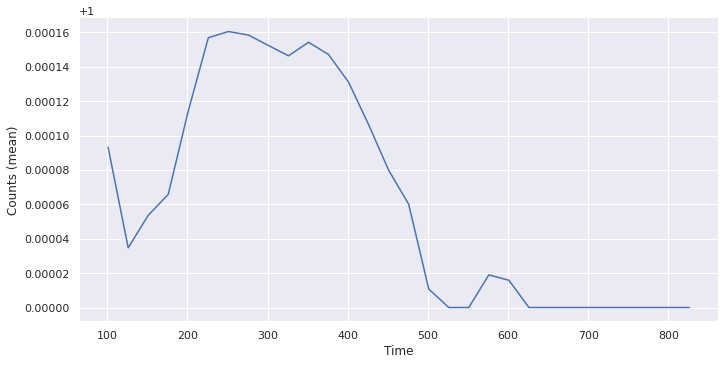

In [87]:
# plotting line plot of moving averages
g = sns.relplot(data=interval, x='timestamp', y='avg_count', kind='line', aspect=2)
g.set_axis_labels('Time', 'Counts (mean)')
plt.show()

### Timing windows

We chose to do aggregations on windows of 25 steps for periods of 100 steps. If the maximum `step` was around 200, then these calculations may not have been as appropiate. This scenario is true for products that are newer, so customer lifespans are on average much shorter. While this holds true, it might be more beneficial to update the metric at each time step. This is a decision that should be made by the analyst while keeping the business context in mind. On the other end of the spectrum, a product that has very long lifespans might be worth analyzing over much longer time periods (e.g. quarters, semesters, years, etc.). This dynamic will be different for different credit cards, because customers will define the product's value and churn at different rates depending on the product itself. Remember that we have to calculate the metrics with the same frequency as the time window specified. That is, if we calculate counts for moving windows of one week looking at the past month, then the metric must be calculated every week.

### Saving metrics data

Calculating metrics is one of the first steps in churn analysis, which means that subsequent analysis will often use these metrics to create statistical models. Using Incorta, we can use materialized views to save a table of metric calculations in a data schema. These tables should contain specific keys and elements that make them easier to query from:

- `account_ID` - identifying individual accounts
- `metric_ID` - identifying type of metrics (you can store multiple metrics in the same table)
- `time` - timestamp corresponding to time at which the metric was measured
- `metric_value` - value of aggregation

The first three variables mentioned here are the unique keys to the metric table that make each row unique. Each row will correspond to a specific account, for which a specific metric was calculated at a specific time. We can use SQL to generate these tables more efficiently than with python, but the logic will be the same as the one used here.

## Sums and averages

Calculating counts is an essential first step, but as we saw in previous sections, we often need to rely on some sort of summary metric to conduct an analysis. The most common aggregations are simple:

- *total* value of all events
- *average* value per event

We have already done some of these calculations, but since we now have the metrics for each account and event, we can outline a general logic to perform the aggregations:

1. Choose dates on which to aggregate
2. Select events within time windows that are of interest
3. Sum or take the mean of the event metric grouping by each account and date

In [90]:
# summing transaction amount per account for rolling windows of 25 steps looking at previous 100 steps
timestamp = []
total_amount = pd.DataFrame()

for t in np.arange(100, 900, 25):
    sum_window = df[(df['step'] > (t-100)) & (df['step'] <= t) & (df['type'] == 'CASH_OUT')]
    moving_sum = sum_window.groupby('nameOrig')['amount'].sum().reset_index().rename(columns={'amount':'total_amount'})
    moving_sum['timestamp'] = t+1
    total_amount = total_amount.append(moving_sum)
    
# showing dataframe for all intervals
total_amount.head(n=10)

,nameOrig,total_amount,timestamp
0,C1000004530,93865.13,101
1,C1000008582,315626.96,101
2,C1000012640,367527.28,101
3,C1000018217,290045.17,101
4,C1000024318,71260.70,101
5,C1000025399,66455.81,101
6,C1000028246,77106.69,101
7,C1000044196,52408.81,101
8,C1000048260,63301.32,101
9,C1000053329,32802.87,101


## Quality assurance (QA)

After calculating metrics, it's important to check whether the results make sense. There are some general strategies that can be helpful. While it might seem tedious, doing QA is fundamental to any churn analysis, especially because if there is even a subtle error in metric calculation, it will alter the results of any posterior analysis. Spot-checking metrics is not sufficient to see whether they are of high quality. Instead, it's important to check for missing data or strange numbers in the data that might require some modifications.

### Metric changes over time

Checking how the metric changes over time is something we already did previously when we checked the average, but it is also worthwhile to check the minimum, maximum, count, and average of the metric and plotting it to see how the changes evolve over time. This is a common technique used in any kind of time-series analysis, and it applies just as well to customer metric aggregations.

In [143]:
# grouping by moving intervals of 100 steps every 25 steps and calculting average transaction amount for each bin
qa_df = pd.DataFrame()
for idx, t in enumerate(np.arange(100, 900, 25)):
    window = df[(df['step'] > (t-100)) & (df['step'] <= t) & (df['type'] == 'CASH_OUT')]
    moving_metric = window.groupby('nameOrig')['amount'].count().reset_index().rename(columns={'amount':'count'})
    
    # appending aggregations to quality assurance dataframe
    desc = moving_metric['count'].describe()
    stat = []
    val = []
    for s in ['min', 'mean', 'max', 'count']:
        stat.append(s)
        val.append(desc.loc[s])
        
    d = {'timestamp':[t+1]*4, 'statistic':stat, 'value':val}
    moving_agg = pd.DataFrame(data=d, index=np.arange(idx,idx+4))
    qa_df = qa_df.append(moving_agg)

# creating dataframe for all intervals
qa_df.head()

,timestamp,statistic,value
0,101,min,1.000000
1,101,mean,1.000093
2,101,max,2.000000
3,101,count,375566.000000
1,126,min,1.000000


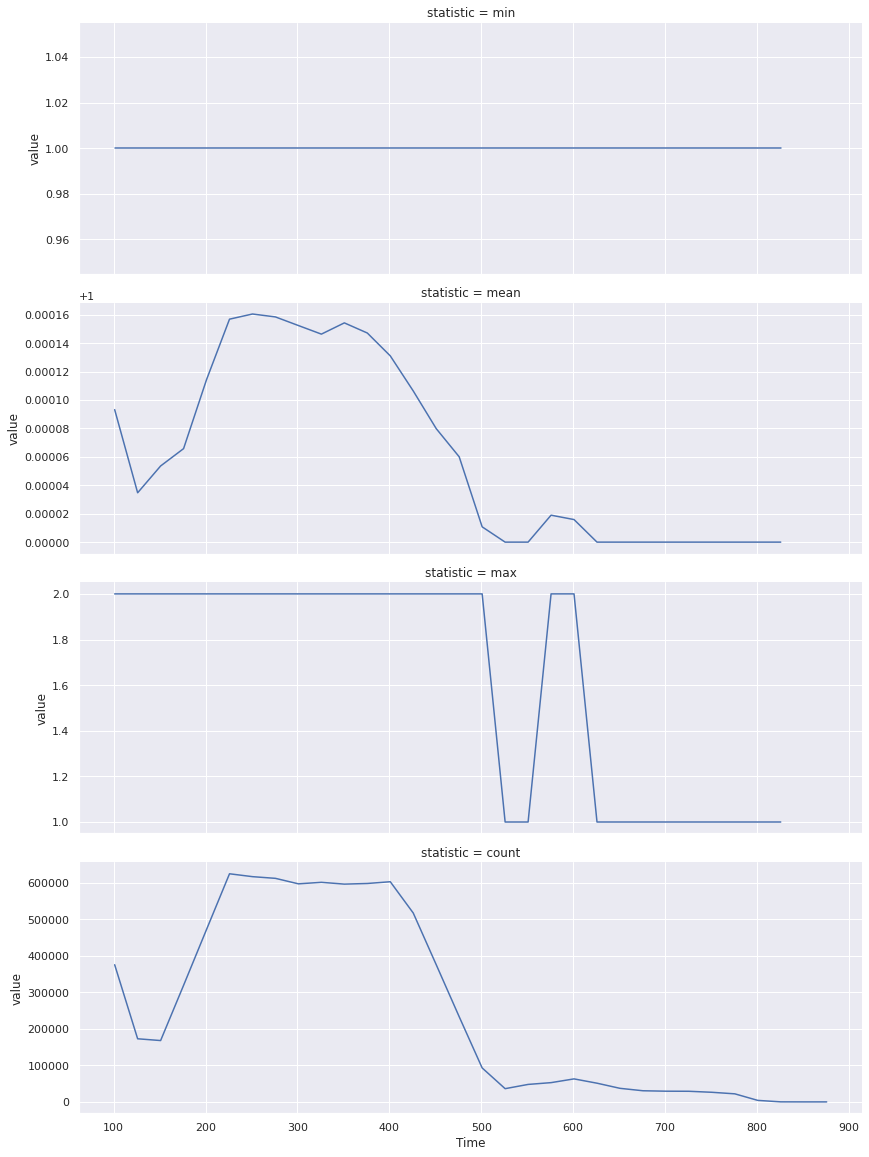

In [144]:
# plotting line plots of time-series statistics
g = sns.relplot(data=qa_df, x='timestamp', y='value', row='statistic', kind='line', height=4, aspect=3, facet_kws={'sharey': False, 'sharex': True})
g.set_axis_labels('Time')
plt.show()

### Accounts with metrics

Another QA technique that is useful is looking at the *percentage* of accounts that receive a metric. A metric will be calculated for different event types, and these events will have varying frequencies over the time window considered. Because of this, some metrics might be calculated many more times than others due to the availability of data. The steps needed to perform this comparison are the following:

1. Choose time window
2. Count the number of accounts in time window
3. Count the number of accounts with a specific metric in time window
4. Calculate proportion of accounts with each metric over all accounts in time window
5. Repeat for other statistics

In [149]:
# grouping by moving intervals of 100 steps every 25 steps and calculting average transaction amount for each bin
qa_df = pd.DataFrame()

# using full time window, we can count number of events and accounts 
for idx, c in enumerate(df['type'].unique()):
    
    #filtering for event type
    event = df[df['type'] == c]
    
    # appending counts to quality assurance dataframe
    d = {'event_type':c, 'count_with_metric':len(event['nameOrig'].unique()), 'n_account':len(df['nameOrig'].unique())}
    moving_agg = pd.DataFrame(data=d, index=[idx])
    moving_agg['pcnt_with_metric'] = moving_agg['count_with_metric'] / moving_agg['n_account']
    qa_df = qa_df.append(moving_agg)

# creating dataframe for all intervals
qa_df

,event_type,count_with_metric,n_account,pcnt_with_metric
0,PAYMENT,2150401,6353307,0.338470
1,TRANSFER,532839,6353307,0.083868
2,CASH_OUT,2236357,6353307,0.351999
3,DEBIT,41432,6353307,0.006521
4,CASH_IN,1398845,6353307,0.220176


### QA for events

Checking events will help with metric design and how the metrics are calculated. This would actually be the first step in the process of calculating customer metrics. The first simple analysis we can do is to check the total number of events for every day for all accounts. We expect to see some sore of cyclical pattern in this time series. If there is any missing data, we should be able to observe this as a gap in the plot between two data points.

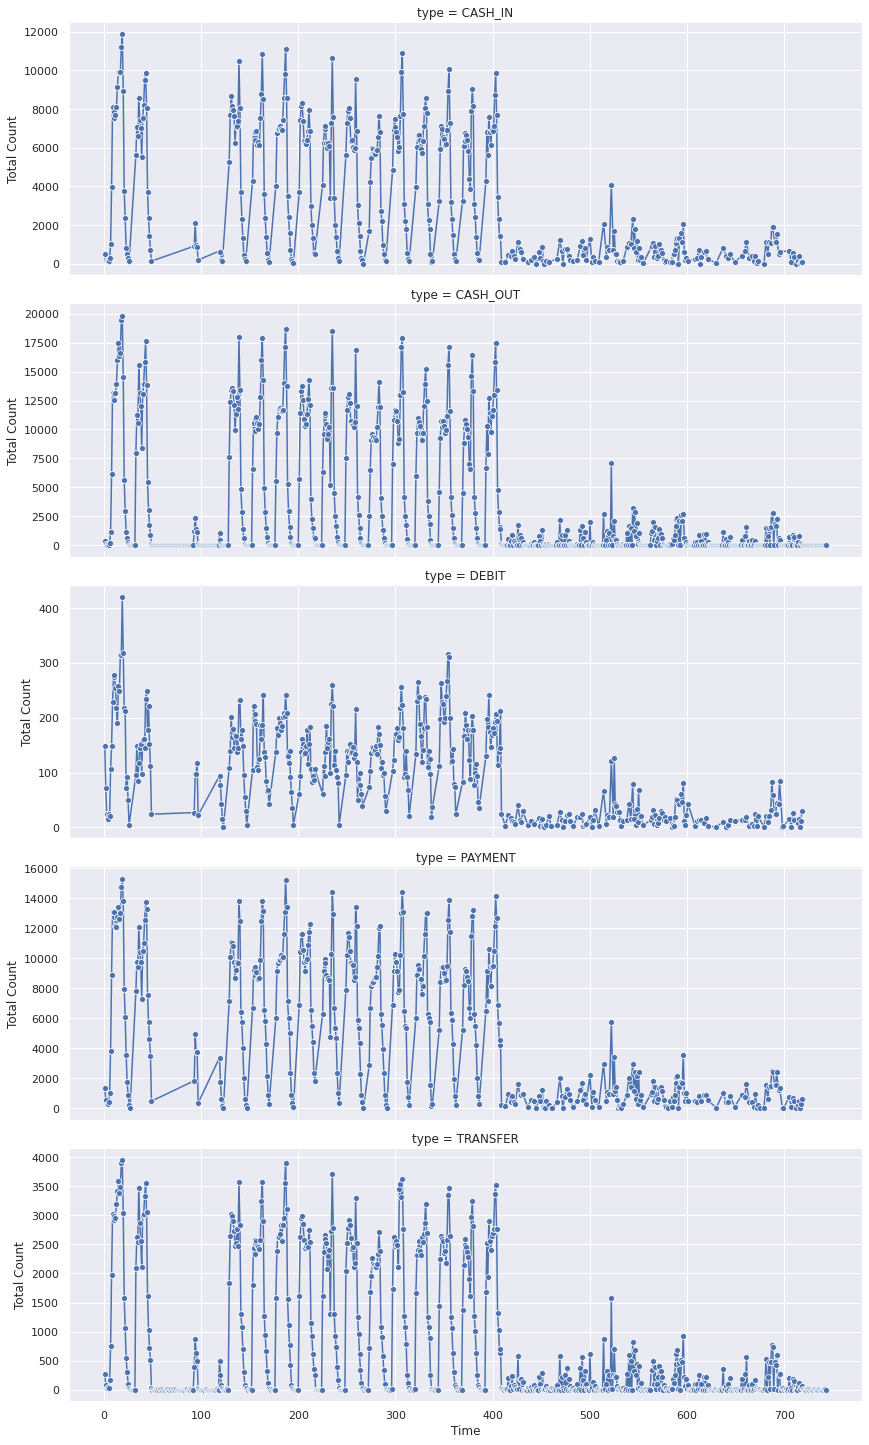

In [141]:
# grouping by time step and calculating average amount
total_events = df.groupby(['step', 'type'])['amount'].count().reset_index().rename(columns={'amount':'count'})

# plotting average transaction amount per time step
g = sns.relplot(data=total_events, x='step', y='count', row='type', kind='line', height=4, aspect=3, facet_kws={'sharey': False, 'sharex': True}, marker='o')
g.set_axis_labels('Time', 'Total Count')
plt.show()

### Events per account

Another useful QA check is counting the number of events for each account. This is slightly different that counting the number of accounts with metrics, which we did previously. The steps to calculate this are the following:

1. Choose time window
2. Count number of accounts in time window
3. Count total number of events in time window
4. Divide total number of events by the number of accounts and by number of time periods (8 in our case)

In [148]:
# grouping by moving intervals of 100 steps every 25 steps and calculting average transaction amount for each bin
qa_df = pd.DataFrame()

# using full time window, we can count number of events and accounts 
for idx, c in enumerate(df['type'].unique()):
    
    #filtering for event type
    event = df[df['type'] == c]
    
    # appending counts to quality assurance dataframe
    d = {'event_type':c, 'n_event':len(event), 'n_account':len(event['nameOrig'].unique())}
    moving_agg = pd.DataFrame(data=d, index=[idx])
    moving_agg['event_per_account'] = moving_agg['n_event'] / moving_agg['n_account']
    moving_agg['n_100_steps'] = 8
    moving_agg['events_per_account_per_100_steps'] = moving_agg['event_per_account'] / moving_agg['n_100_steps']
    qa_df = qa_df.append(moving_agg)

# creating dataframe for all intervals
qa_df

,event_type,n_event,n_account,event_per_account,n_100_steps,events_per_account_per_100_steps
0,PAYMENT,2151495,2150401,1.000509,8,0.125064
1,TRANSFER,532909,532839,1.000131,8,0.125016
2,CASH_OUT,2237500,2236357,1.000511,8,0.125064
3,DEBIT,41432,41432,1.000000,8,0.125000
4,CASH_IN,1399284,1398845,1.000314,8,0.125039


## Measurement period

Choosing a measurement period for metrics depends on the relative frequency of the event itself. The more infrequent an event is, the longer the measurement period should be. This is because if an event is rare and measurement periods are short, then there will be many measurement periods without any events, and the ones that do have events will act more like anomalies rather than behavioral summaries. Each metric has two components that need to be understood by the business in order to choose the time period. Metrics have a level of *responsiveness* to changes in time, and each metric has a *sensitivity* to the occurence of an event. A good rule of thumb is that the minimum time period for a behavioral metric should be at least two times the average frequency of the event. In the case of our data, if 100 time steps corresponds to one month, and the events per account per month is around 0.125 for all event types, then more than 6 months will pass before we expect another event to happen, which means that the time period used for measuring should be at least 12 months:

$$\frac{1}{EventsPerAccountPerMonth}=E(MonthsPerEvent)$$  

$$\Rightarrow E(MonthsPerEvent) \times 2 \leq min(MeasurePeriod)$$

## Account tenure

All metrics so far are based on the the occurence of events, but we might also care about the amount of time that a customer has been active. This will be referred to as *account tenure*, which is directly related to churn because tenures end when a customer decides to churn. For the simulation data, we do not know when customers opened their accounts, so we can assume that the first transaction corresponds to an opening of the account and we can calculate different tenures for customers based on that. Another thing worth mentioning is that customers might open and close accounts, which would restart a tenure from zero. These gaps of inactivity can be small or large, so it is up to the analyst to decide how long a gap is allowed before an account is considered to be starting over. For the sake of simplicity, we'll look at three sample accounts and calculate their tenures.

In [220]:
three_trx

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig
537473,21,CASH_OUT,342781.58,C1976208114,0.00,0.00
553970,22,PAYMENT,18811.75,C1784010646,429.00,0.00
1098627,130,CASH_IN,308685.51,C1530544995,22323.00,331008.51
2239282,186,CASH_IN,179357.71,C1530544995,5394600.26,5573957.96
2699744,211,CASH_IN,366563.73,C1784010646,8832558.59,9199122.32
2869623,227,PAYMENT,6228.53,C1976208114,0.00,0.00
2895229,228,PAYMENT,2491.87,C1530544995,105416.00,102924.13
4359348,309,CASH_OUT,51324.77,C1784010646,12285.00,0.00
4652048,330,TRANSFER,162120.24,C1976208114,0.00,0.00


In [227]:
# taking subsample of accounts
three_trx = df.query("nameOrig == 'C1530544995' | nameOrig == 'C1784010646' | nameOrig == 'C1976208114'")

# defining tenure
tenure_df = pd.DataFrame()
for a in three_trx['nameOrig'].unique():
    one_trx = three_trx[three_trx['nameOrig'] == a]
    start = one_trx['step'].min()
    tenure = []
    time = []
    for idx, t in enumerate(np.arange(start, 501, 1)):
        time.append(t)
        if (one_trx['step'] == t).any():
            if (idx == 0) or (t - start > 100):
                tenure.append(0)
            else:
                tenure.append(tenure[idx-1]+1)
        else:
            tenure.append(tenure[idx-1]+1)
    
    # appending to tenure dataframe
    d = {'time':time, 'tenure':tenure, 'account':a}
    tenure_df = tenure_df.append(pd.DataFrame(data=d))
    
tenure_df.head()

,time,tenure,account
0,21,0,C1976208114
1,22,1,C1976208114
2,23,2,C1976208114
3,24,3,C1976208114
4,25,4,C1976208114


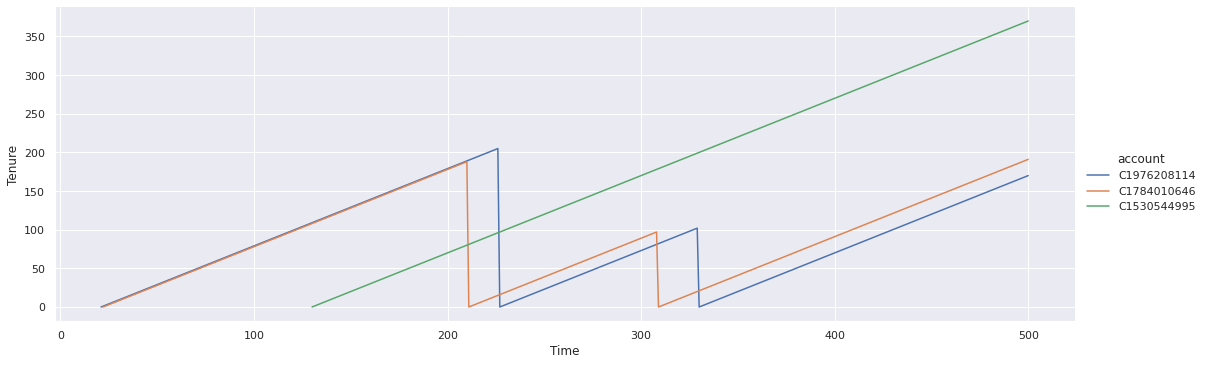

In [228]:
# plotting tenure
g = sns.relplot(data=tenure_df, x='time', y='tenure', hue='account', kind='line', aspect=3)
g.set_axis_labels('Time', 'Tenure')
plt.show()

## Other metrics

### MRR

Total monthly recurring revenue (MRR) is important when the amount customers pay to use the product is important. In the context of credit cards, MRR is positive when a customer uses their card. If they churn (become inactive), then MRR is equal to zero. When they do use the card, there are two possible scenarios: they settle their balance every billing cycle, or they carry their balance into the next cycle. If they settle their balance, then MRR is equal to the interchange fee, which is quite small. A significant additional revenue is generated when the customer carries their balance, as they then have to pay interest on their revolving balance. MRR is a useful metric that may be worth adding to the library of event-based metrics already covered.

### Units, quantities, and billing periods

Continuing with the credit card example, the product can have different tiers (gold, silver, platinum, etc.) that allow customers different levels of usage. For example, a silver cardholder may be allowed 10 transactions per day up to a certain amount, while a gold cardholer might be allowed 20 transactions. In this example, the ability to make transactions would be the *unit* and number of transactions would be the *quantity*. Different card tiers might also charge different APRs and offer different fee structures, so on top of the number of transactions the customer is allowed, they are also have a unique *charge* for usage of the card depending on their card tier and other factors. These charges occur over specific *billing periods*, which refer to how often the customer is billed for their usage of the product. All three of these variables can be used as addditional behavioral metrics in churn analysis. We are unable to use the simulation data to calculate these metrics, but real-world data will often contain the fields necessary to make the aggregations.